# 初始设置

导入必需的库。
convlstm的实现来自https://github.com/ndrplz/ConvLSTM_pytorch

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import glob
from convlstm import ConvLSTM

# 数据集处理
创建自定义的数据加载器。

In [2]:
class ViolenceDataset(Dataset):
    def __init__(self, pose_paths, change_paths, labels):
        """
        参数:
            pose_paths (list): 包含所有骨架 .npy 文件的完整路径列表
            change_paths (list): 包含所有帧差 .npy 文件的完整路径列表 (必须与 pose_paths 一一对应)
            labels (list): 对应的标签列表 (1 代表暴力, 0 代表非暴力)
        """
        self.pose_paths = pose_paths
        self.change_paths = change_paths
        self.labels = labels
        
        # 确保两个模态的数据量和标签量一致
        assert len(self.pose_paths) == len(self.change_paths) == len(self.labels), \
            f"数据对齐错误: Pose文件数={len(self.pose_paths)}, Change文件数={len(self.change_paths)}, 标签数={len(self.labels)}"

    def __len__(self):
        return len(self.pose_paths)

    def __getitem__(self, idx):
        # 直接通过完整路径加载数据，.npy文件里已经是 (Frames, H, W, C) 的格式
        pose_data = np.load(self.pose_paths[idx])
        change_data = np.load(self.change_paths[idx])
        
        # 转换为 PyTorch 格式 (T, C, H, W)
        pose_data = torch.from_numpy(pose_data).permute(0, 3, 1, 2).float()
        change_data = torch.from_numpy(change_data).permute(0, 3, 1, 2).float()
        
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        return pose_data, change_data, label

返回两个文件夹内共有的.npy文件列表。

In [3]:
def get_aligned_paths(pose_dir, change_dir):
    """
    读取两个对应的文件夹，通过文件名匹配确保数据一一对应
    """
    # 获取文件名（不带路径），用于求交集
    pose_files = {f for f in os.listdir(pose_dir) if f.endswith('.npy')}
    change_files = {f for f in os.listdir(change_dir) if f.endswith('.npy')}
    
    # 取交集，防止某个视频只提取了 pose 没提取 change
    common_files = sorted(list(pose_files & change_files))
    
    if len(common_files) < len(pose_files):
        print(f"警告: {pose_dir} 中有 {len(pose_files)-len(common_files)} 个文件无法在 {change_dir} 中找到对应项，将被忽略。")
    
    # 生成完整路径列表
    pose_paths = [os.path.join(pose_dir, f) for f in common_files]
    change_paths = [os.path.join(change_dir, f) for f in common_files]
    
    return pose_paths, change_paths

一键创建 DataLoaders。

In [4]:
def create_dataloaders(data_root, batch_size=8, test_size=0.2, num_workers=4):
    """
    参数:
        data_root: 数据集根目录
    """
    # 定义子文件夹路径
    dirs = {
        "fight_pose": os.path.join(data_root, "fights_pose_npy"),
        "fight_change": os.path.join(data_root, "fights_change_npy"),
        "nofight_pose": os.path.join(data_root, "noFights_pose_npy"),
        "nofight_change": os.path.join(data_root, "noFights_change_npy"),
    }

    # 1. 获取配对的文件路径
    fight_p, fight_c = get_aligned_paths(dirs["fight_pose"], dirs["fight_change"])
    nofight_p, nofight_c = get_aligned_paths(dirs["nofight_pose"], dirs["nofight_change"])
    
    # 2. 生成标签
    fight_y = [1] * len(fight_p)
    nofight_y = [0] * len(nofight_p)
    
    # 3. 合并
    all_p = fight_p + nofight_p
    all_c = fight_c + nofight_c
    all_y = fight_y + nofight_y
    
    print(f"Dataset summary: Total samples: {len(all_y)} (Fight: {len(fight_y)}, NoFight: {len(nofight_y)})")

    # 4. 划分训练集和验证集
    train_p, val_p, train_c, val_c, train_y, val_y = train_test_split(
        all_p, all_c, all_y, 
        test_size=test_size, 
        random_state=42, 
        stratify=all_y # 保证验证集正负样本比例一致
    )

    # 5. 创建 Dataset 实例
    train_ds = ViolenceDataset(train_p, train_c, train_y)
    val_ds = ViolenceDataset(val_p, val_c, val_y)

    # 6. 创建 DataLoader
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader

# 网络架构

In [5]:
class ViolenceDetector(nn.Module):
    def __init__(self, num_frames=50, height=100, width=100):
        super(ViolenceDetector, self).__init__()
        self.num_frames = num_frames
        
        # --- 配置 ---
        self.fusion_channels = 9 
        
        # ==========================================
        # 1. Pose/RGB Pipeline (已替换为 MobileNetV2)
        # ==========================================
        # 加载预训练的 MobileNetV2
        # pretrained=True 让模型自带识别形状的能力，对骨架图非常有效
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.pose_backbone = mobilenet.features

        # --- 新增：冻结参数 ---
        for param in self.pose_backbone.parameters():
            param.requires_grad = False
        
        # 适配层 (Adapter)：
        # MobileNetV2 的输出是 (Batch, 1280, H/32, W/32)
        # 我们需要把它变成 (Batch, 9, H, W) 才能和下面的 Change 流相加
        self.pose_adapter = nn.Sequential(
            nn.Conv2d(1280, self.fusion_channels, kernel_size=1), # 降维: 1280 -> 9
            nn.BatchNorm2d(self.fusion_channels),
            nn.ReLU(),
            # 关键：因为 MobileNet 把图片变小了 (100x100 -> 4x4)，必须插值放大回去
            nn.Upsample(size=(height, width), mode='bilinear', align_corners=False) 
        )
        
        # ==========================================
        # 2. Change Pipeline (保持不变)
        # ==========================================
        self.change_convlstm = ConvLSTM(input_dim=3, 
                                        hidden_dim=self.fusion_channels, 
                                        kernel_size=(3, 3), 
                                        num_layers=1, 
                                        batch_first=True, 
                                        bias=True, 
                                        return_all_layers=False)
        
        # --- 3. Temporal Aggregation (保持不变) ---
        self.agg_convlstm = ConvLSTM(input_dim=self.fusion_channels, 
                                     hidden_dim=32, 
                                     kernel_size=(3, 3), 
                                     num_layers=1, 
                                     batch_first=True, 
                                     bias=True, 
                                     return_all_layers=False)
        
        # --- 4. Post-processing (保持不变) ---
        self.post_conv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        
        # --- 5. Classification Head (保持不变) ---
        # --- 修改分类头，加入 Dropout ---
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),  # <--- 新增：丢弃 50% 的神经元
            nn.Linear(128, 16),
            nn.ReLU(),
            nn.Dropout(0.2),  # <--- 新增：丢弃 20% 的神经元
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, pose_seq, change_seq):
        b, t, c, h, w = pose_seq.size()

        # ===========================
        # 1. Pose/RGB Path Processing (修改后)
        # ===========================
        # 将 Batch 和 Time 维度合并，让 CNN 一次处理所有帧
        pose_reshaped = pose_seq.view(b * t, c, h, w)
        
        # MobileNetV2 提取特征
        # 输入: (B*T, 3, 100, 100) -> 输出: (B*T, 1280, 4, 4)
        features = self.pose_backbone(pose_reshaped) 
        
        # 适配层调整: 降维并放大回 100x100
        # 输出: (B*T, 9, 100, 100)
        rgb_feat = self.pose_adapter(features)
        
        # 恢复时间维度，准备给 ConvLSTM 或 融合
        rgb_feat = rgb_feat.view(b, t, self.fusion_channels, h, w)

        # ===========================
        # 2. Change Path Processing (保持不变)
        # ===========================
        change_out_list, _ = self.change_convlstm(change_seq)
        change_feat = change_out_list[0] 
        change_feat = torch.tanh(change_feat)

        # ===========================
        # 3. Fusion (Add) (保持不变)
        # ===========================
        # 现在 rgb_feat 和 change_feat 都是 (B, T, 9, 100, 100)，可以直接相加
        fused_feat = rgb_feat + change_feat

        # ===========================
        # 4. Temporal Aggregation (保持不变)
        # ===========================
        _, last_states = self.agg_convlstm(fused_feat)
        h_agg = last_states[0][0] 

        # ===========================
        # 5. Classification (保持不变)
        # ===========================
        out = self.post_conv(h_agg) 
        out = self.gap(out)         
        predictions = self.classifier(out) 
        
        return predictions

# 训练过程
配置与辅助函数定义。

In [6]:
# --- 配置参数 ---
DATA_ROOT = "../data/RWF2000" 
train_loader, val_loader = create_dataloaders(DATA_ROOT, batch_size=16)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4  # 学习率
SAVE_DIR = "./checkpoints-v2.0" # 模型保存路径
# 是否继续训
NUM_EPOCHS = 30       # 训练轮数
RESUME_PATH = None 
# RESUME_PATH = "./checkpoints/last_checkpoint.pth"

# 确保保存路径存在
os.makedirs(SAVE_DIR, exist_ok=True)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 使用 tqdm 包装 loader，显示进度条
    loop = tqdm(loader, desc="Training", leave=False)
    
    for batch_idx, (pose, change, labels) in enumerate(loop):
        # 移动数据到 GPU
        # 输入维度: (B, T, C, H, W)
        pose = pose.to(device)
        change = change.to(device)
        # 标签维度调整: (B) -> (B, 1) 以匹配模型输出
        labels = labels.to(device).unsqueeze(1) 
        
        # 1. 前向传播
        outputs = model(pose, change) # -> (B, 1)
        loss = criterion(outputs, labels)
        
        # 2. 反向传播与优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 3. 统计指标
        predicted = (outputs > 0.5).float() # 阈值 0.5
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        
        # 4. 实时更新进度条上的 Loss 和 Acc
        loop.set_postfix(loss=loss.item(), acc=correct/total)
        
    return running_loss / len(loader), correct / total

def validate(model, loader, criterion, device):
    model.eval() # 切换到评估模式
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad(): # 验证阶段不需要计算梯度
        loop = tqdm(loader, desc="Validation", leave=False)
        for pose, change, labels in loop:
            pose = pose.to(device)
            change = change.to(device)
            labels = labels.to(device).unsqueeze(1)
            
            outputs = model(pose, change)
            loss = criterion(outputs, labels)
            
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
            loop.set_postfix(loss=loss.item(), acc=correct/total)
            
    return running_loss / len(loader), correct / total

Dataset summary: Total samples: 2000 (Fight: 1000, NoFight: 1000)


初始化模型与优化器。

In [7]:
# 1. 初始化模型
print(f"Initializing model on {DEVICE}...")
model = ViolenceDetector(num_frames=50).to(DEVICE)

# 2. 定义损失函数和优化器
criterion = nn.BCELoss() # 二分类交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Initializing model on cuda...


/home/jovyan/envs/fightingDetection/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jovyan/envs/fightingDetection/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


训练。

In [8]:
# --- 存储训练数据的列表 ---
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# --- 配置参数 ---
start_epoch = 0
best_val_acc = 0.0

if RESUME_PATH and os.path.exists(RESUME_PATH):
    print(f"Loading checkpoint from {RESUME_PATH}...")
    checkpoint = torch.load(RESUME_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint.get('best_val_acc', 0.0)
    
    # --- 新增：尝试读取历史数据 ---
    if 'history' in checkpoint:
        history = checkpoint['history']
        train_losses = history.get('train_losses', [])
        train_accs = history.get('train_accs', [])
        val_losses = history.get('val_losses', [])
        val_accs = history.get('val_accs', [])
        print(f"Restored history: {len(train_losses)} epochs.")
    
    print(f"Resuming from Epoch {start_epoch}. (Previous Best Acc: {best_val_acc:.4f})")
else:
    print("Starting fresh training...")

print("-" * 60)

# --- 定义函数 (Batch级 tqdm) ---
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 修改点：使用 tqdm 包装 loader
    # leave=True 表示跑完后保留进度条，leave=False 表示跑完后消失
    loop = tqdm(loader, desc="Training", leave=True)
    
    for batch_idx, (pose, change, labels) in enumerate(loop):
        pose = pose.to(device)
        change = change.to(device)
        labels = labels.to(device).unsqueeze(1)
        
        # Forward
        outputs = model(pose, change)
        loss = criterion(outputs, labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Metrics
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        
        # 修改点：实时更新进度条后缀
        loop.set_postfix(loss=loss.item(), acc=correct/total)
        
    return running_loss / len(loader), correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 修改点：使用 tqdm 包装 loader
    loop = tqdm(loader, desc="Validation", leave=True)
    
    with torch.no_grad():
        for pose, change, labels in loop:
            pose = pose.to(device)
            change = change.to(device)
            labels = labels.to(device).unsqueeze(1)
            
            outputs = model(pose, change)
            loss = criterion(outputs, labels)
            
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            
            # 修改点：实时更新进度条后缀
            loop.set_postfix(loss=loss.item(), acc=correct/total)
            
    return running_loss / len(loader), correct / total

# --- 主循环 ---
for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    
    # 训练
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # 验证
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)
    
    # 记录
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # 打印本轮总结
    print(f"Summary -> Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_path = os.path.join(SAVE_DIR, "best_model.pth")
        torch.save(model.state_dict(), save_path)
        print(f"Best model saved with Acc: {best_val_acc:.4f}")
    
    # 保存 Checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_acc': best_val_acc,
        
        # --- 新增：保存历史数据 ---
        'history': {
            'train_losses': train_losses,
            'train_accs': train_accs,
            'val_losses': val_losses,
            'val_accs': val_accs
        }
    }
    torch.save(checkpoint, os.path.join(SAVE_DIR, "last_checkpoint.pth"))

print("\nTraining Complete.")

Starting fresh training...
------------------------------------------------------------

Epoch 1/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  2.87it/s, acc=0.642, loss=0.654]


Summary -> Train Loss: 0.6874, Acc: 0.5375 | Val Loss: 0.6622, Acc: 0.6425
Best model saved with Acc: 0.6425

Epoch 2/30


Validation: 100%|██████████| 25/25 [00:07<00:00,  3.21it/s, acc=0.715, loss=0.567]


Summary -> Train Loss: 0.6356, Acc: 0.6781 | Val Loss: 0.5847, Acc: 0.7150
Best model saved with Acc: 0.7150

Epoch 3/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  2.81it/s, acc=0.698, loss=0.599]


Summary -> Train Loss: 0.5875, Acc: 0.7212 | Val Loss: 0.5904, Acc: 0.6975

Epoch 4/30


Validation: 100%|██████████| 25/25 [00:07<00:00,  3.16it/s, acc=0.703, loss=0.604]


Summary -> Train Loss: 0.5680, Acc: 0.7319 | Val Loss: 0.5671, Acc: 0.7025

Epoch 5/30


Validation: 100%|██████████| 25/25 [00:07<00:00,  3.20it/s, acc=0.7, loss=0.592]  


Summary -> Train Loss: 0.5516, Acc: 0.7394 | Val Loss: 0.5632, Acc: 0.7000

Epoch 6/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  2.98it/s, acc=0.725, loss=0.598]


Summary -> Train Loss: 0.5535, Acc: 0.7344 | Val Loss: 0.5556, Acc: 0.7250
Best model saved with Acc: 0.7250

Epoch 7/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s, acc=0.725, loss=0.643]


Summary -> Train Loss: 0.5366, Acc: 0.7431 | Val Loss: 0.5499, Acc: 0.7250

Epoch 8/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  3.02it/s, acc=0.74, loss=0.607] 


Summary -> Train Loss: 0.5413, Acc: 0.7400 | Val Loss: 0.5328, Acc: 0.7400
Best model saved with Acc: 0.7400

Epoch 9/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  3.03it/s, acc=0.745, loss=0.632]


Summary -> Train Loss: 0.5243, Acc: 0.7581 | Val Loss: 0.5182, Acc: 0.7450
Best model saved with Acc: 0.7450

Epoch 10/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  2.93it/s, acc=0.757, loss=0.607]


Summary -> Train Loss: 0.5122, Acc: 0.7688 | Val Loss: 0.5316, Acc: 0.7575
Best model saved with Acc: 0.7575

Epoch 11/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  3.05it/s, acc=0.765, loss=0.605]


Summary -> Train Loss: 0.5017, Acc: 0.7750 | Val Loss: 0.5183, Acc: 0.7650
Best model saved with Acc: 0.7650

Epoch 12/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  3.09it/s, acc=0.755, loss=0.633]


Summary -> Train Loss: 0.4959, Acc: 0.7800 | Val Loss: 0.5219, Acc: 0.7550

Epoch 13/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  3.12it/s, acc=0.772, loss=0.579]


Summary -> Train Loss: 0.4913, Acc: 0.7756 | Val Loss: 0.5167, Acc: 0.7725
Best model saved with Acc: 0.7725

Epoch 14/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s, acc=0.782, loss=0.588]


Summary -> Train Loss: 0.4758, Acc: 0.7837 | Val Loss: 0.4923, Acc: 0.7825
Best model saved with Acc: 0.7825

Epoch 15/30


Validation: 100%|██████████| 25/25 [00:07<00:00,  3.15it/s, acc=0.71, loss=0.681] 


Summary -> Train Loss: 0.4774, Acc: 0.7850 | Val Loss: 0.5680, Acc: 0.7100

Epoch 16/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  2.91it/s, acc=0.745, loss=0.649]


Summary -> Train Loss: 0.4699, Acc: 0.7981 | Val Loss: 0.5173, Acc: 0.7450

Epoch 17/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s, acc=0.777, loss=0.558]


Summary -> Train Loss: 0.4618, Acc: 0.7969 | Val Loss: 0.5101, Acc: 0.7775

Epoch 18/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s, acc=0.787, loss=0.568]


Summary -> Train Loss: 0.4575, Acc: 0.7969 | Val Loss: 0.4870, Acc: 0.7875
Best model saved with Acc: 0.7875

Epoch 19/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s, acc=0.765, loss=0.599]


Summary -> Train Loss: 0.4284, Acc: 0.8125 | Val Loss: 0.5190, Acc: 0.7650

Epoch 20/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  2.92it/s, acc=0.785, loss=0.595]


Summary -> Train Loss: 0.4529, Acc: 0.8081 | Val Loss: 0.4917, Acc: 0.7850

Epoch 21/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  2.88it/s, acc=0.79, loss=0.647] 


Summary -> Train Loss: 0.4359, Acc: 0.8131 | Val Loss: 0.4987, Acc: 0.7900
Best model saved with Acc: 0.7900

Epoch 22/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  2.97it/s, acc=0.772, loss=0.569]


Summary -> Train Loss: 0.4377, Acc: 0.8075 | Val Loss: 0.5026, Acc: 0.7725

Epoch 23/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  3.03it/s, acc=0.772, loss=0.619]


Summary -> Train Loss: 0.4168, Acc: 0.8275 | Val Loss: 0.5100, Acc: 0.7725

Epoch 24/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  3.06it/s, acc=0.782, loss=0.668]


Summary -> Train Loss: 0.4206, Acc: 0.8131 | Val Loss: 0.4973, Acc: 0.7825

Epoch 25/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  3.02it/s, acc=0.74, loss=0.762] 


Summary -> Train Loss: 0.4082, Acc: 0.8219 | Val Loss: 0.5491, Acc: 0.7400

Epoch 26/30


Validation: 100%|██████████| 25/25 [00:07<00:00,  3.17it/s, acc=0.77, loss=0.688] 


Summary -> Train Loss: 0.4074, Acc: 0.8356 | Val Loss: 0.5288, Acc: 0.7700

Epoch 27/30


Validation: 100%|██████████| 25/25 [00:07<00:00,  3.15it/s, acc=0.715, loss=0.68] 


Summary -> Train Loss: 0.4133, Acc: 0.8137 | Val Loss: 0.5512, Acc: 0.7150

Epoch 28/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  3.09it/s, acc=0.74, loss=0.708] 


Summary -> Train Loss: 0.3969, Acc: 0.8287 | Val Loss: 0.5252, Acc: 0.7400

Epoch 29/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  2.95it/s, acc=0.765, loss=0.689]


Summary -> Train Loss: 0.3760, Acc: 0.8381 | Val Loss: 0.5108, Acc: 0.7650

Epoch 30/30


Validation: 100%|██████████| 25/25 [00:08<00:00,  3.02it/s, acc=0.767, loss=0.712]

Summary -> Train Loss: 0.3849, Acc: 0.8419 | Val Loss: 0.5859, Acc: 0.7675

Training Complete.


画图。

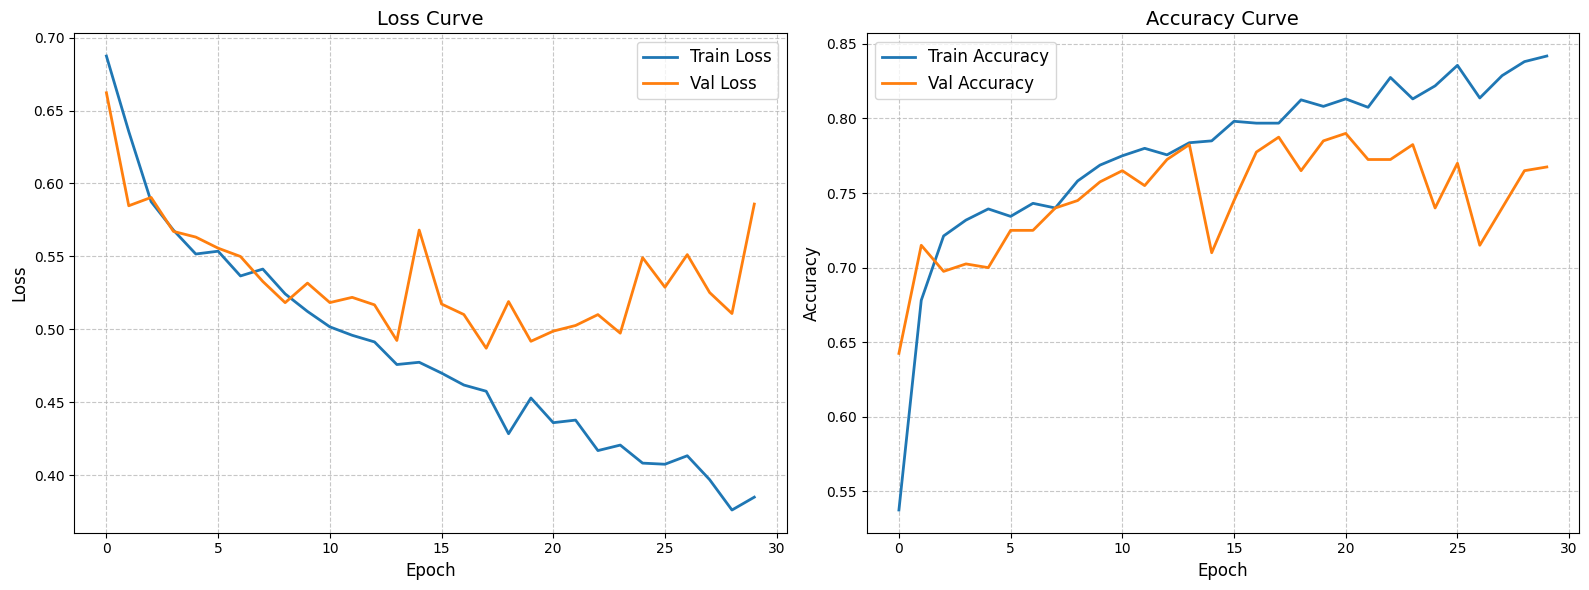

In [9]:
# 创建画布，1行2列
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- 绘制 Loss 曲线 ---
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', linewidth=2)
axes[0].set_title('Loss Curve', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.7)

# --- 绘制 Accuracy 曲线 ---
axes[1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[1].plot(val_accs, label='Val Accuracy', linewidth=2)
axes[1].set_title('Accuracy Curve', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()